---
layout: post
title: Deep Learning from Scratch
date: 2023-03-09
category: AI
tags: machine-learning, python, neural-networks, deep-learning
---

The purpose of this post is twofold. One, with so much jargon in the deep learning space, I want to present my interpretation of several key components of artificial neural networks. Second, while high-level APIs like [Keras](https://keras.io/) and [fastai](https://docs.fast.ai/) make deep learning so accessible and make the Problem -> Architecture -> Training -> Inference pipleine so seamless, I want to work through the underlying mechanics of a basic neural network. This demonstration is largely inspired by the [Chapter 4 notebook](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) of the book *Deep Learning for Coders with fastai & PyTorch* by Jeremy Howard and Sylvain Gugger. In the book, the authors trained a binary digit classifier using the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) to predict 3s vs 7s. Here, I present a multiclass classifier to predict whether a handwritten digit is a 0, 1, 2, 3, 4, 5, 6, 7, 8, or 9 (10 classes).

In [1]:
from keras.datasets import mnist
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import torch
import torch.nn.functional as F
import random
import tensorflow as tf

if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

random.seed(9)
np.random.seed(9)
torch.cuda.manual_seed(9)
torch.manual_seed(9)
torch.backends.cudnn.deterministic = True
tf.random.set_seed(9)

# Load and Explore Data

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

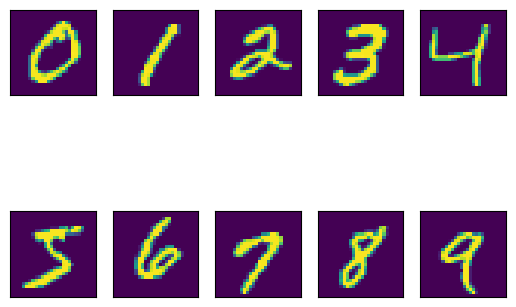

In [3]:
# plot an example from each class
fig, axs = plt.subplots(nrows=2, ncols=5)
for i in range(10):
  first_example = np.where(train_y == i)[0][0]
  ax = plt.subplot(2, 5, i + 1)
  ax.imshow(train_X[first_example])
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)

# Baseline Approach

As a baseline, we can find the "average" of each digit 0-9 by averaging pixels across all training examples. Then, we can use [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) to classify a new example as the average digit to which it is closest, a nearest-neighbor-esque approach. We will then use [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) as the metric for the neural network to beat.


In [4]:
average_digits = {}
for i in range(10):
  average_digits[i] = train_X[np.argwhere(train_y == i).flatten()].mean(0)

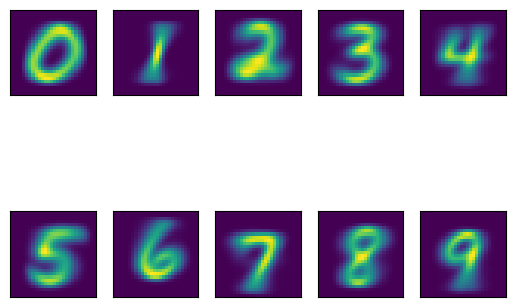

In [5]:
# plot the "average" of each class
fig, axs = plt.subplots(nrows=2, ncols=5)
for i in range(10):
  ax = plt.subplot(2, 5, i + 1)
  ax.imshow(average_digits[i])
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)

In [6]:
def mse(input, target):
  return np.square(input - target).mean()

def get_pred(input, average_digits_dict):
  return np.argmin(np.array([mse(input, average_digits_dict[x]) for x in range(10)]))

In [7]:
get_pred_partial = partial(get_pred, average_digits_dict=average_digits)
print(f"Accuracy : {(np.fromiter(map(get_pred_partial, test_X), dtype=int) == test_y).mean()}")

Accuracy : 0.8203


# Deep Neural Network

The baseline model does a decent job, getting about 82% of digits in the holdout set correct. Hopefully, our neural network will perform considerably better.

In [8]:
# convert data to tensors
train_X_pt = (torch.tensor(train_X).view(-1,28*28).float()/255).to(device)
train_y_pt = F.one_hot(torch.tensor(train_y, dtype=int), num_classes=10).to(device)
train_X_pt.shape, train_y_pt.shape

(torch.Size([60000, 784]), torch.Size([60000, 10]))

Each image has 28x28 = 784 pixels. Ultimaltely, we wish to run those 784 pieces of data through a series of functions to consolidate that into 10 numbers that sum to 1. Each of those numbers will represent a probability that the digit belongs to a particular class 0-9. We can then assign the digit to belong to the class with the highest probability.

We transform the initial length 784 vector of pixel values by multiplying them by a random matrix of weights with dimension 784x64. 64 is an arbitrary choice. The larger the number, the more complex the network architecture, which equates to greater computational compexity, the ability to detect a larger number of features, and a greater risk of overfitting the data. To complete the slope-intercept form of a line, $y=mx+b$, each of the 64 weights additionally comes with bias term, also randomly initialized. Perhaps the most crucial component of the model specification is the [rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks), an activation function that introduces the property of non-linearity. This function takes the maximum of 0 and x for each element, x, of the vector produced by multiplying the pixel vector by the weight matrix and adding the bias terms. We then repeat the process to make the network "deep", carefully crafting weight matrices and bias vecrtors to ensure that input vectors can be multiplied. The final layer produces 10 values, corresponding to the 10 classes, and a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation is used to create a valid distribution of probabilities. Passing the input data through this flow of mappings encapsulates a *forward pass* through the network.


In [9]:
def init_params(size, std=0.2):
  # multiply by std for numeric stability
  return (torch.randn(size)*std).to(device).requires_grad_()

In [10]:
w1 = init_params((28*28,64))
b1 = init_params(64)
w2 = init_params((64,64))
b2 = init_params(64)
w3 = init_params((64,10))
b3 = init_params(10)

In [11]:
def neural_net(x):
  res = x@w1 + b1 # hidden layer 1
  res =  res.max(torch.tensor(0.0)) # activation
  res =  res@w2 + b2 # hidden layer 2
  res =  res.max(torch.tensor(0.0)) # activation
  res =  res@w3 + b3 # hidden layer 3
  return res.softmax(1) # activation

As the model is intitialized with random values, we are now faced with an optimization problem. In other words, we are tasked with finding values for the weights and biases, our parameters, which yield sensible predictions. We do this by minimizing a loss function, here [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy), using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). The gradients inform us of the impact on the loss by adjusting each of our parameters up or down. Here, PyTorch is able to calculate gradients using calculus's chain rule: the loss is calculated using cross-entropy, which in turn takes class predictions as input, which was calculated using the functions and parameters specified in the neural network. Rather than adjusting the parameters by the negative of the gradient (to *decrease* loss), we multiply by a hyperparameter known as the *learning rate* to ensure our steps along the gradient aren't too large.  This is the *backward pass* of the network. The forward and backward passes are repeated for the desired number of epochs.

In [12]:
def cross_entropy(predictions, targets):
    loss = -torch.sum(targets*torch.log(predictions))
    return loss

In [13]:
learning_rate = 0.00001
num_epochs = 3000
for epoch in range(num_epochs):
  pred = neural_net(train_X_pt)
  loss = cross_entropy(pred, train_y_pt)
  loss.backward()
  # display loss every 500 epochs
  if (epoch+1) % 500 == 0:
    print(loss)
  for p in (w1,b1,w2,b2,w3,b3):
    p.data -= p.grad*learning_rate
    p.grad.zero_()

tensor(7322.0781, device='cuda:0', grad_fn=<NegBackward0>)
tensor(5211.2217, device='cuda:0', grad_fn=<NegBackward0>)
tensor(3177.1079, device='cuda:0', grad_fn=<NegBackward0>)
tensor(2225.7097, device='cuda:0', grad_fn=<NegBackward0>)
tensor(1577.9738, device='cuda:0', grad_fn=<NegBackward0>)
tensor(1117.8452, device='cuda:0', grad_fn=<NegBackward0>)


In [14]:
preds = neural_net((torch.tensor(test_X).view(-1,28*28).float()/255).to(dev)).softmax(1)
print(f"Accuracy: {((preds.argmax(dim=1) - torch.tensor(test_y).to(dev)) == 0).sum() / preds.size(0)}")

Accuracy: 0.9697999954223633


With an accuracy of almost 97% in the holdout dataset, we beat our baseline model considerably. Several other techniques (e.g., [convolutions](https://en.wikipedia.org/wiki/Convolutional_neural_network)) could be leveraged to improve the model even further. As a motivating example, here is an implementation of an architecture known as LeNet-5 [(LeCun et al., 1998)](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz).


![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)



In [15]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.AveragePooling2D())

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.AveragePooling2D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=120, activation='relu'))

model.add(tf.keras.layers.Dense(units=84, activation='relu'))

model.add(tf.keras.layers.Dense(units=10, activation = 'softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 13, 13, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_X, tf.keras.utils.to_categorical(train_y),
                    batch_size=128, epochs=100, validation_split=0.2,
                    callbacks=[callback])

Epoch 1/100
375/375 [==============================] - 10s 5ms/step - loss: 0.4338 - accuracy: 0.9005 - val_loss: 0.1231 - val_accuracy: 0.9620
Epoch 2/100
375/375 [==============================] - 2s 5ms/step - loss: 0.1000 - accuracy: 0.9693 - val_loss: 0.0936 - val_accuracy: 0.9697
Epoch 3/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0664 - accuracy: 0.9791 - val_loss: 0.0722 - val_accuracy: 0.9787
Epoch 4/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0506 - accuracy: 0.9843 - val_loss: 0.0732 - val_accuracy: 0.9783
Epoch 5/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0393 - accuracy: 0.9871 - val_loss: 0.0606 - val_accuracy: 0.9827
Epoch 6/100
375/375 [==============================] - 3s 7ms/step - loss: 0.0335 - accuracy: 0.9890 - val_loss: 0.0550 - val_accuracy: 0.9834
Epoch 7/100
375/375 [==============================] - 2s 5ms/step - loss: 0.0288 - accuracy: 0.9906 - val_loss: 0.0595 - val_accuracy: 0.983

In [17]:
print(f"Accuracy: {((model.predict(test_X).argmax(axis=1) - test_y) == 0).sum() / preds.size(0)}")

313/313 [==============================] - 1s 2ms/step
Accuracy: 0.9858
